In [2]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
# dataset: 
# https://chronicdata.cdc.gov/Behavioral-Risk-Factors/Behavioral-Risk-Factor-Surveillance-System-BRFSS-P/
df = pd.read_csv('Behavioral_Risk.csv')

# we drop columns that have more than 50% of data missing
drop_cols = ['Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 
             'DataSource', 'Data_value_unit', 'Data_value_type', 'QuestionID', 
             'ResponseID', 'LocationID', 'TopicId', 'ClassId', 'BreakoutID', 
             'BreakOutCategoryID', 'Display_order']

df.drop(axis=1, columns=drop_cols, inplace=True)
# irrelevant fields

df.drop(axis=1, columns=['Year', 'GeoLocation'], inplace=True)

# fill missing values with median values

nul_cols = ['Data_value', 'Confidence_limit_Low', 'Confidence_limit_High']

for col in nul_cols:
    df[col].fillna(df[col].mean(), inplace=True)


In [3]:
df['Class'].unique()

array(['Alcohol Consumption', 'Demographics', 'Cholesterol Awareness',
       'Chronic Health Indicators', 'Health Care Access/Coverage',
       'Health Status', 'Hypertension Awareness', 'Immunization',
       'Injury', 'Overweight and Obesity (BMI)', 'Physical Activity',
       'Tobacco Use', 'Colorectal Cancer Screening', 'Oral Health',
       'Prostate Cancer', "Women's Health", 'Fruits and Vegetables',
       'HIV-AIDS', 'E-Cigarette Use'], dtype=object)

In [4]:
df['Locationdesc'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Connecticut', 'Colorado', 'Delaware', 'Florida', 'Georgia',
       'District of Columbia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Nebraska', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'North Carolina', 'Ohio', 'New York',
       'North Dakota', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'South Carolina', 'South Dakota', 'Rhode Island', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Washington', 'Vermont',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam',
       'All States and DC (median) **', 'Puerto Rico',
       'All States, DC and Territories (median) **', 'Virgin Islands'],
      dtype=object)

In [5]:
def choose_data(df, location, topic):

    result = pd.DataFrame(df.loc[df['Locationdesc']==location])
    result = pd.DataFrame(result.loc[result['Class']==topic])
    result.drop(axis=1, columns=['Locationabbr', 'Locationdesc', 'Class', 'Topic'], inplace=True)
    result.drop(axis=1, columns=['Data_value', 'Confidence_limit_Low', 'Confidence_limit_High'], inplace=True)
    result = pd.DataFrame(result.groupby(['Question', 'Break_Out_Category', 'Break_Out', 'Response']).sum())
    result.to_csv('tmp.csv')
    result = pd.read_csv('tmp.csv')
    return result

In [6]:
#TODO
#calculate data value for every break out category
def data_calculator(df):
    
    n_people = pd.DataFrame(df.groupby(['Question', 'Break_Out_Category'], as_index=False).sum())
    j = 0
    while j<n_people.shape[0]:
        for i in range(df.shape[0]):
            if df.at[i, 'Question']==n_people.at[j, 'Question'] and df.at[i, 'Break_Out_Category']==n_people.at[j, 'Break_Out_Category']:
                df.at[i, 'Data_value'] = df.at[i, 'Sample_Size'] / n_people.at[j, 'Sample_Size'] * 100
        j+=1
    return df

In [7]:
def reformat_df(df):
    
    result = df.reset_index().pivot_table(index='Break_Out', columns=['Question', 'Response'], values=['Data_value']) 
    for col in result:
        result[col] = pd.to_numeric(result[col])
        result[col].fillna(value = result[col].mean(), inplace=True)
    #for col in result:
        #result[col].fillna(value = result[col].mean(), inplace=True)
    #result.fillna(value=0, inplace=True)
    return result

In [8]:
def load_data(df, location, topic):
    data = choose_data(df, location, topic)
    data = data_calculator(data)
    data = reformat_df(data)
    return data

In [9]:
def calculate_cosine_similarity(df1, df2):
    
    X = df1.values
    Y = df2.values
    X = X.astype(float)
    Y = Y.astype(float)
    cos_sim = cosine_similarity(X.reshape(1, -1), Y.reshape(1, -1))
    return 1 - cos_sim

In [10]:
whealth_ny = load_data(df, 'New York', 'Women\'s Health')
whealth_texas = load_data(df, 'New York', 'Women\'s Health')
whealth_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, $15,000-$24,999 to White, non-Hispanic
Data columns (total 10 columns):
Data_value      36 non-null float64
Data_value.1    36 non-null float64
Data_value.2    36 non-null float64
Data_value.3    36 non-null float64
Data_value.4    36 non-null float64
Data_value.5    36 non-null float64
Data_value.6    36 non-null float64
Data_value.7    36 non-null float64
Data_value.8    36 non-null float64
Data_value.9    36 non-null float64
dtypes: float64(10)
memory usage: 3.1+ KB


In [50]:
calculate_cosine_similarity(whealth_ny, whealth_texas)

array([[-2.22044605e-16]])

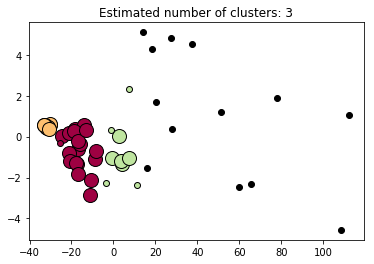

In [183]:
from sklearn.cluster import DBSCAN

X = ny_alabama.values
reduced_data = PCA(n_components=2).fit_transform(X)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

db = DBSCAN(eps=4.9).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

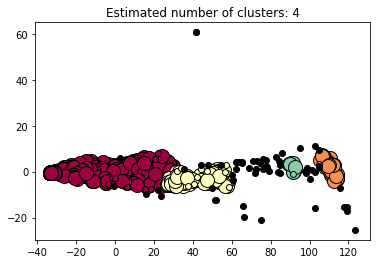

In [189]:
from sklearn.cluster import DBSCAN

X = tobacco_data.values
reduced_data = PCA(n_components=2).fit_transform(X)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

db = DBSCAN(eps=2.5).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [11]:
tobacco_data = []
for location in df['Locationdesc'].unique():
    tobacco_data.append(load_data(df, location, 'Tobacco Use'))

In [15]:
tobacco = pd.concat(tobacco_data)

In [16]:
tobacco.shape

(1406, 9)

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
X = tobacco.values

pca = PCA(n_components=2)

reduced_data = pca.fit_transform(X)

print(pca.explained_variance_ratio_)


[0.98412656 0.00915421]


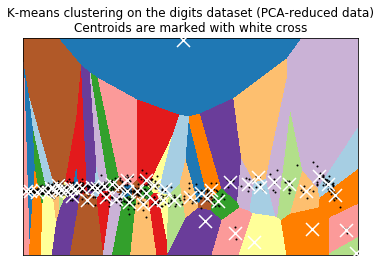

In [23]:
kmeans = KMeans(init='k-means++', n_clusters=len(tobacco_data), n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

locations = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Connecticut', 'Colorado', 'Delaware', 'Florida', 'Georgia',
       'District of Columbia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Nebraska', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'North Carolina', 'Ohio', 'New York',
       'North Dakota', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'South Carolina', 'South Dakota', 'Rhode Island', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Washington', 'Vermont',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam']

topics = ['Alcohol Consumption', 'Demographics', 'Cholesterol Awareness',
       'Chronic Health Indicators', 'Health Care Access/Coverage',
       'Health Status', 'Hypertension Awareness', 'Immunization',
       'Injury', 'Overweight and Obesity (BMI)', 'Physical Activity',
       'Tobacco Use', 'Colorectal Cancer Screening', 'Oral Health',
       'Prostate Cancer', "Women's Health", 'Fruits and Vegetables',
       'HIV-AIDS', 'E-Cigarette Use']

dataframes = []
for location in locations:
    data = []
    for topic in topics:
        tmp = load_data(df, location, topic)
        reduced = pca.fit_transform(tmp.values)
        data.append(reduced.flatten())
    dataframes.append(data)

In [62]:
dataframes[0]
#data1[0][0]


[array([ -3.95814147, -21.75701957, -17.84229395,  20.44588303,
        -33.99030708, -27.28820269, -23.14881945, -13.56576986,
         -0.85711352,  21.48244872, -29.25162235, -29.89884149,
          2.80940705,   5.09377474,  73.9901575 ,  14.95717553,
        -40.61694002, -12.78069091, -19.62134206,  19.82530129,
        -40.90737116, -30.20871722, -40.10607913, 136.61126445,
          7.7701691 ,  82.81369053]),
 array([ -8.01564076, -34.67702675, -26.43785972,  48.32119185,
        -54.22028841, -42.3191908 , -36.60473287, -20.17705148,
          0.45245451,  35.83825129, -68.46781279, -69.4283842 ,
          4.48294264,  16.86761502, 118.55783282,  24.9764955 ,
        -66.72608293, -25.99754422, -35.98417407,  39.73207177,
        -67.05625359, -69.96208229, -65.60362622, 239.03004466,
         16.74722131, 146.6716297 ]),
 array([ -2.65427621, -16.2421295 , -12.77699173,  20.06371304,
        -29.35683856, -24.07450033, -18.02346862,  -8.41649139,
          3.08225006,  21.36

In [63]:
states_matrices = dict(zip(locations, dataframes))

In [16]:
len(dataframes[0][0][0])

1

In [71]:
states_dataframe = pd.DataFrame.from_dict(states_matrices)
for col in states_dataframe:    
    for i in range(states_dataframe.shape[0]):
        states_dataframe.at[i, col] = np.linalg.norm(states_dataframe.at[i, col])
states_dataframe

,Alabama,Alaska,Arizona,Arkansas,California,Connecticut,Colorado,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Virginia,Washington,Vermont,West Virginia,Wisconsin,Wyoming,Guam
0,210.133,208.791,216.188,221.644,194.107,225.254,220.572,210.285,209.878,204.792,...,223.995,199.983,235.882,214.251,224.754,232.459,234.217,217.434,234.701,173.265
1,370.379,403.646,402.792,390.534,362.143,428.05,422.334,393.666,390.525,373.643,...,391.481,369.275,433.357,404.085,425.446,445.002,409.219,420.825,440.047,324.158
2,175.768,173.52,181.05,181.699,165.578,194.368,189.193,184.273,185.007,174.607,...,187.202,167.902,183.014,184.158,191.754,200.765,190.752,184.565,196.05,135.975
3,412.445,450.842,436.503,429.935,415.853,467.334,465.807,437.088,428.562,418.939,...,438.211,414.449,482.118,449.677,465.654,489.334,455.857,466.15,480.873,391.358
4,226.612,224.981,240.449,239.504,211.474,262.55,246.7,240.608,230,222.28,...,240.198,214.261,248.18,244.171,254.1,271.853,252.983,253.906,255.242,176.535
5,110.623,126.021,122.218,114.587,114.391,134.164,132.816,122.683,117.581,114.394,...,116.888,112.607,136.099,124.852,132.789,140.58,121.388,130.206,135.293,102.662
6,84.9539,91.6135,88.2094,88.3842,85.2836,94.0636,95.72,88.7905,88.4188,84.4797,...,89.643,83.2146,100.664,90.4862,94.8053,100.239,93.3603,92.599,97.9207,81.4864
7,167.528,169.976,170.575,171.821,163.366,180.114,178.512,172.445,170.792,162.552,...,176.185,162.694,181.177,170.355,180.419,182.729,184.589,174.768,181.23,148.016
8,193.757,200.846,206.812,197.948,193.483,220.536,212.722,205.674,199.955,195.728,...,203.343,197.842,212.713,208.711,221.229,221.801,212.167,207.361,210.586,164.664
9,48.3174,52.0485,49.8019,49.7321,47.7374,51.628,53.5734,51.2742,47.9511,50.247,...,50.4666,46.2412,55.4394,49.9174,52.7893,56.2474,52.45,52.5881,57.3393,45.1176


In [ ]:
from sklearn.cluster import DBSCAN

pca = PCA(n_components=2)
X = states_dataframe.values
reduce = pca.fit_transform(X)

db = DBSCAN(eps=150).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()